

## Basic Multi-agent Collaboration 기초예제


In [1]:
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core duckduckgo-search langchain-community


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [ ]:
# "당신은 다른 AI 어시스턴트들과 협력하는 유용한 AI 어시스턴트입니다."
# "질문에 답을 진행하기 위해 제공된 도구들을 사용하세요."
# "만약 질문에 완전히 답하지 못하더라도 괜찮습니다. 다른 도구를 가진 또 다른 어시스턴트가"
# "당신이 멈춘 부분을 도울 것입니다. 할 수 있는 만큼 실행하여 진전을 이루세요."
# "만약 당신이나 다른 어시스턴트가 최종 답변이나 결과물을 가지고 있다면,"
# "응답의 시작에 'FINAL ANSWER'라고 표기하여 팀이 멈추도록 하세요."
# "당신은 다음 도구들에 접근할 수 있습니다: {tool_names}.\n{system_message}"

In [8]:
from typing import Annotated

from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper

wrapper = DuckDuckGoSearchAPIWrapper(region="de-de", time="d", max_results=2)

duck_tool = DuckDuckGoSearchResults(api_wrapper=wrapper, source="news")





In [4]:
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [22]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.model_dump(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

In [23]:
# Research agent and node
research_agent = create_agent(
    llm,
    [duck_tool],
    system_message="You should provide accurate data for use, "
        "and source code shouldn't be the final answer",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [24]:
# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Run the python code to display the chart.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

In [25]:
from langgraph.prebuilt import ToolNode

tools = [duck_tool, python_repl]
tool_node = ToolNode(tools)

In [26]:
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [27]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0sQJ4eZDm939DCA5RGO7ejGO', 'function': {'arguments': '{"query": "South Korea GDP 2022"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}, {'id': 'call_gpFQ59jGxbXr1U5eY0hcskKB', 'function': {'arguments': '{"query": "South Korea GDP 2021"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}, {'id': 'call_pDm4a8yosqZ0MfHY2FvlhmiN', 'function': {'arguments': '{"query": "South Korea GDP 2020"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 221, 'total_tokens': 307, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_432e014d75', 'id': 'chatcmpl-BL0SRD8TAsPYlIneZ

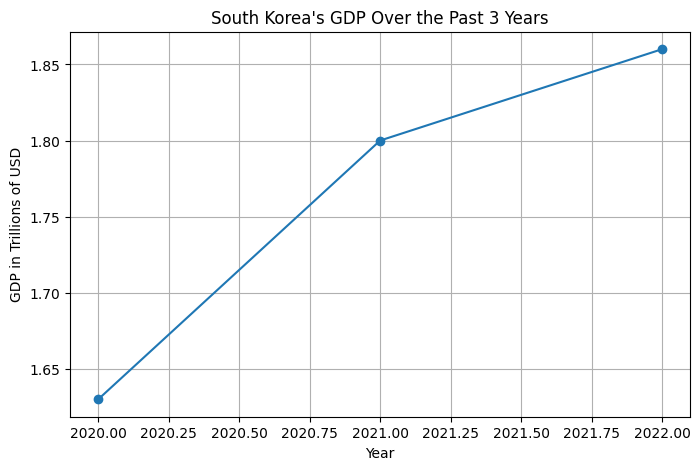

{'chart_generator': {'messages': [AIMessage(content="I have found the following GDP data for South Korea for the past three years:\n\n- 2020: $1.63 trillion (estimated)\n- 2021: $1.8 trillion (estimated)\n- 2022: $1.86 trillion (estimated)\n\nWith this data, I'll proceed to code the line graph.", additional_kwargs={'tool_calls': [{'id': 'call_fekSYMX1MkeyDyxZtMkPBJzD', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Define the years and GDP values\\nyears = [2020, 2021, 2022]\\ngdp_values = [1.63, 1.8, 1.86]\\n\\n# Create the line plot\\nplt.figure(figsize=(8, 5))\\nplt.plot(years, gdp_values, marker=\'o\')\\n\\n# Adding title and labels\\nplt.title(\\"South Korea\'s GDP Over the Past 3 Years\\")\\nplt.xlabel(\\"Year\\")\\nplt.ylabel(\\"GDP in Trillions of USD\\")\\n\\n# Show the plot\\nplt.grid(True)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 224, 'prompt_tokens': 3

In [33]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the SOUTH KOREA's GDP over the past 3 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 20},
)
for s in events:
    print(s)
    print("----")